## Auslesen der Dateien ##

Achtung: Die Dateien aus dem ersten Verzeichnis (hier D:/hka-aqm-m) müssen extrahiert vorliegen (d.h. nicht als zip-Ordner).

hka-aqm-m

            > ... .dat

            > ... .dat

In [1]:
from ML_Preparation.Preprocessing_M import DataExtractor, DataPreprocessing

de = DataExtractor("CO2_sensor_data/hka-aqm-m", "CO2_sensor_data/extracted_data")

df = de.create_df()

No .dat files found in C:/Users/danie/building_M_data. 
 Trying to extract files from the original directory D:/hka-aqm-m
Read data successfully.
Data contains 979166 data points and 18 columns.


## Preprocessing ##

df_preprocessed := Datensatz mit Wetterdaten und Jahreszeiten

df_preprocessed_without_weather := Datensatz ohne Wetterdaten, aber mit Jahreszeiten

df_preprocessed_without_seasons := Datensatz mit Wetterdaten, aber ohne Jahreszeiten

In [2]:
label = "CO2"

dp = DataPreprocessing(label = label)

df_preprocessed = dp.preprocess_df(df, rolling_window = "3d", sample_time = "1d")

Number of outliers detected: -73438
Number of normal samples detected: 905728


In [3]:
df_preprocessed.columns

Index(['date_time', 'tmp', 'hum', 'CO2', 'VOC', 'vis', 'IR', 'BLE', 'tavg',
       'tmin', 'tmax', 'wdir', 'wspd', 'wpgt', 'pres', 'room_number',
       'tmp_diff', 'hum_diff', 'VOC_diff', 'vis_diff', 'IR_diff', 'BLE_diff',
       'tavg_diff', 'tmin_diff', 'tmax_diff', 'wdir_diff', 'wspd_diff',
       'wpgt_diff', 'pres_diff', 'year', 'dayofweek', 'hour', 'season',
       'VOC_CO2_ratio'],
      dtype='object')

In [4]:
df_preprocessed_without_weather = df_preprocessed.drop(columns = ['tavg',
       'tmin', 'tmax', 'wdir', 'wspd', 'wpgt', 'pres',  'tavg_diff', 'tmin_diff', 'tmax_diff', 'wdir_diff', 'wspd_diff',
       'wpgt_diff', 'pres_diff'], axis = 1)

df_preprocessed_without_seasons = df_preprocessed.drop(columns = ["season"], axis = 1)

## Feature Engineering ##

In [5]:
from ML_Preparation.Feature_Engineering import *

n_steps = 1

fe = FeatureEngineering(df_preprocessed,
                        label = label, 
                        categorical_features = ["season", "room_number", "dayofweek"],
                        automated_feature_engineering = False)

X_train, X_val, X_test, y_train, y_val, y_test = fe.feature_engineering(steps_to_forecast = n_steps, skip_scale = True)

In [6]:
fe_no_weather = FeatureEngineering(df_preprocessed_without_weather,
                        label = label, 
                        categorical_features = ["season", "room_number", "dayofweek"],
                        automated_feature_engineering = False)

X_train_nowe, X_val_nowe, X_test_nowe, y_train_nowe, y_val_nowe, y_test_nowe = fe_no_weather.feature_engineering(steps_to_forecast = n_steps, skip_scale = True)

fe_no_seasons = FeatureEngineering(df_preprocessed_without_seasons,
                        label = label, 
                        categorical_features = ["room_number", "dayofweek"],
                        automated_feature_engineering = False)

X_train_nose, X_val_nose, X_test_nose, y_train_nose, y_val_nose, y_test_nose = fe_no_seasons.feature_engineering(steps_to_forecast = n_steps, skip_scale = True)

## Modelltraining ##

In [7]:
from Forecasting_Evaluation.Forecasting_Models import CO2_Forecasting_Model
from matplotlib import pyplot

trainierte Modelle laden

In [8]:
import tensorflow as tf

train_models = False

try:
    model = tf.keras.models.load_model(f"{label}_Forecasting_Model.keras")
    model_no_weather = tf.keras.models.load_model(f"{label}_Forecasting_Model_no_weather.keras")
    model_no_seasons = tf.keras.models.load_model(f"{label}_Forecasting_Model_no_seasons.keras")
except:
    print("Models couldn't be loaded. Train new models.")
    train_models = True

Models couldn't be loaded. Train new models.


c:\Users\danie\anaconda3\envs\awp1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



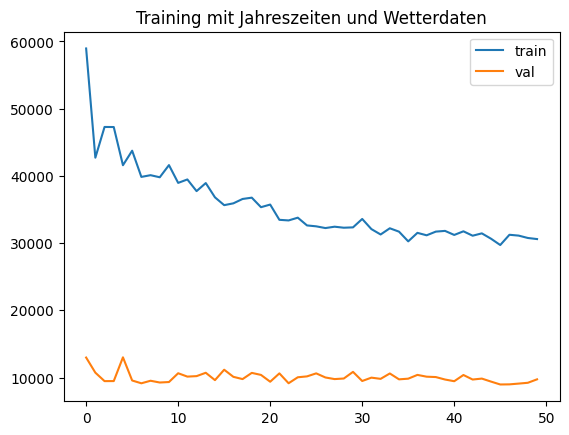

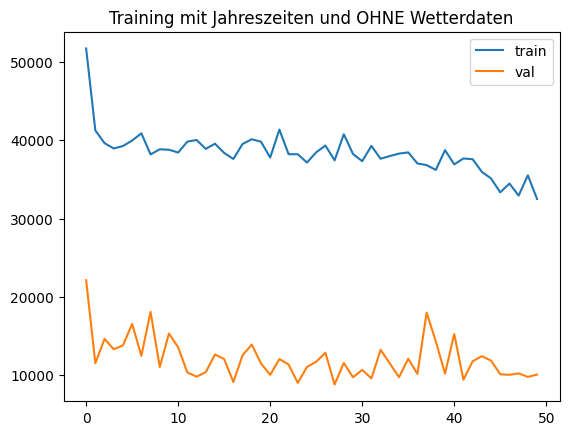

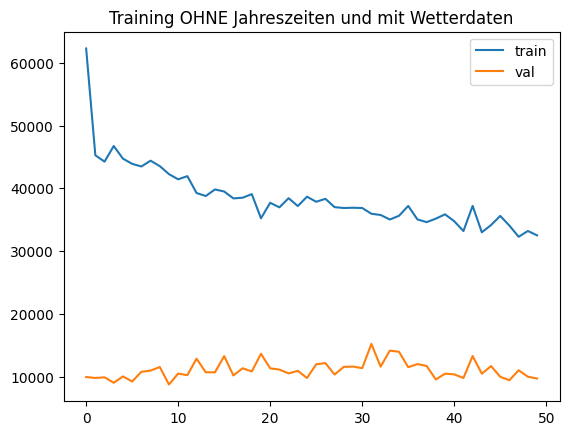

In [17]:
if train_models:    
    # Instantiate the model
    model = CO2_Forecasting_Model(n_steps, fe)

    history = model.model.fit(fe.X_train, fe.y_train, epochs=50, batch_size = 16, 
                                validation_data = (fe.X_val, fe.y_val),
                                verbose = 0, 
                                shuffle=False
                                )

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history["val_loss"], label = "val")
    pyplot.title("Training mit Jahreszeiten und Wetterdaten")
    pyplot.legend()
    pyplot.show()



    model_no_weather = CO2_Forecasting_Model(n_steps, fe_no_weather)

    history = model_no_weather.model.fit(fe_no_weather.X_train, fe_no_weather.y_train, epochs=50, batch_size=16, 
                                        validation_data = (fe_no_weather.X_val, fe_no_weather.y_val),
                                        verbose = 0, 
                                        shuffle=False
                                        )

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history["val_loss"], label = "val")
    pyplot.title("Training mit Jahreszeiten und OHNE Wetterdaten")
    pyplot.legend()
    pyplot.show()

    model_no_seasons = CO2_Forecasting_Model(n_steps, fe_no_seasons)

    history = model_no_seasons.model.fit(fe_no_seasons.X_train, fe_no_seasons.y_train, epochs=50, batch_size = 16, 
                                        validation_data = (fe_no_seasons.X_val, fe_no_seasons.y_val),
                                        verbose = 0, 
                                        shuffle=False
                                    )

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history["val_loss"], label = "val")
    pyplot.title("Training OHNE Jahreszeiten und mit Wetterdaten")
    pyplot.legend()
    pyplot.show()

In [18]:
if train_models:
    model.model.save(f"{label}_Forecasting_Model.keras")
    model_no_weather.model.save(f"{label}_Forecasting_Model_no_weather.keras")
    model_no_seasons.model.save(f"{label}_Forecasting_Model_no_seasons.keras")

    pred = model.model.predict(fe.X_test)
    pred_no_weather = model_no_weather.model.predict(fe_no_weather.X_test)
    pred_no_seasons = model_no_seasons.model.predict(fe_no_seasons.X_test)
else:
    pred = model.predict(fe.X_test)
    pred_no_weather = model_no_weather.predict(fe_no_weather.X_test)
    pred_no_seasons = model_no_seasons.predict(fe_no_seasons.X_test)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


## Modellevaluation ##

In [19]:
import plotly.express as px
import seaborn as sns
from Forecasting_Evaluation.Evaluator import Evaluator


ev = Evaluator()

for col in range(0, fe.y_test.shape[1]):
    print(f"t +", col)
    print("Modell mit Wetterdaten und Jahreszeiten (rot)")
    ev.evaluate(y_true = fe.y_test[:, col], y_pred = pred[:, col])
    print("Modell ohne Wetterdaten und mit Jahreszeiten (grün)")
    ev.evaluate(y_true = fe_no_weather.y_test[:, col], y_pred = pred_no_weather[:, col])
    print("Modell mit Wetterdaten und ohne Jahreszeiten (violett)")
    ev.evaluate(y_true = fe_no_seasons.y_test[:, col], y_pred = pred_no_seasons[:, col])

    px.line(y = [fe.y_test[:, col], pred[:, col], pred_no_weather[:,col], pred_no_seasons[:, col]], 
             labels = {"wide_variable_0": "y_true",
                        "wide_variable_1": "Modell 1 - Vorhersage (Wetterdaten + Jahreszeiten)", 
                       "wide_variable_2": "Modell 2 - Vorhersage (Jahreszeiten)",
                       "wide_variable_3": "Modell 3 - Vorhersage (Wetterdaten)", },
             title = f"Prediction for CO2(t + {col})  blue = y_true, red = y_pred").show()


t + 0
Modell mit Wetterdaten und Jahreszeiten (rot)
MSE:  5918.96
RMSE:  76.93
MAPE:  0.11
R2:  -0.2


Modell ohne Wetterdaten und mit Jahreszeiten (grün)
MSE:  6721.72
RMSE:  81.99
MAPE:  0.12
R2:  -0.36


Modell mit Wetterdaten und ohne Jahreszeiten (violett)
MSE:  5595.16
RMSE:  74.8
MAPE:  0.1
R2:  -0.13




## Deployment bzw. Inferenz mit dem trainierten Modell ##

In [20]:
from Deployment.ML_Deployment import *

fe.df = df.copy()

deployer = Predictor(data = df, feature_engineering_class_object = fe, label = "CO2", is_forecast = True, roll = True, steps_to_forecast = 7)


In [21]:
deployer.df.shape

(6403, 33)

In [22]:
deployer.x.shape

(6403, 1, 68)

In [23]:
if train_models:
    forecasted_pred = deployer.predict(x = deployer.x, model = model.model)
else:
    forecasted_pred = deployer.predict(x = deployer.x, model = model)

forecasted_pred

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,prediction_t+0,room_number
date_time,,
2022-06-01,525.494690,m001
2022-06-02,511.711487,m001
2022-06-03,510.403503,m001
2022-06-04,509.491150,m001
2022-06-20,437.667908,m104
...,...,...
2023-09-26,512.904236,m306
2023-09-26,483.909210,m301
2023-09-26,527.844910,m003
